<hr style="color:green" />
<h1 style="color:green">COSC2673 Assignment 2: Image Classification for Cancerous Cells</h1>
<h2 style="color:green">File 06: Basic PyTorch Fully Connected Neural Network model test on Main data</h2>
<hr style="color:green" />

<p>
In this file, attempt to apply techniques to deal with overfitting on the Basic 01 (3 layer FC NN) model. Experiment with L2 Regularization, Dropout maybe early stopping
</p>

In [1]:
import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image


Configure this script as to whether it runs on Google Colab, or locally

In [2]:
# When on Google Colab, running full training, change both to true. Locally, advised set both to false
isGoogleColab = True
useFullData = True

In [3]:
# In local, the base directory is the current directory
baseDirectory = "./"

if isGoogleColab:
    from google.colab import drive
    
    # If this is running on Google colab, assume the notebook runs in a "COSC2673" folder, which also contains the data files 
    # in a subfolder called "image_classification_data"
    drive.mount("/content/drive")
    !ls /content/drive/'My Drive'/COSC2673/

    # Import the directory so that custom python libraries can be imported
    import sys
    sys.path.append("/content/drive/MyDrive/COSC2673/")

    # Set the base directory to the Google Drive specific folder
    baseDirectory = "/content/drive/MyDrive/COSC2673/"

Mounted at /content/drive
05a.PyTorchGetMeanAndStd.ipynb	     dataframe_utility.py
06.PyTorchBasic01.ipynb		     graphing_utility.py
07.PyTorchBasic02.ipynb		     Image_classification_data
08.PyTorchBasic03.ipynb		     Image_classification_data.zip
09.PyTorchBasic01_TuneLR.ipynb	     images_main.csv
10.PyTorchBasic01_CV.ipynb	     __pycache__
11.PyTorchBasic01_overfitting.ipynb  pytorch_utility.py
a2_utility.py			     statistics_utility.py
data_basic_utility.py


Import the custom python files that contain reusable code

In [4]:
import data_basic_utility as dbutil
import graphing_utility as graphutil
import statistics_utility as statsutil

import a2_utility as a2util
import pytorch_utility as ptutil
from pytorch_utility import CancerBinaryDataset
from pytorch_utility import CancerCellTypeDataset


# randomSeed = dbutil.get_random_seed()
randomSeed = 266305
print("Random Seed: " + str(randomSeed))

Random Seed: 266305


In [5]:
# this file should have previously been created in the root directory
dfImages = pd.read_csv(baseDirectory + "images_main.csv")

In [6]:
# Get The training Split and the Validation Split
dfImagesTrain = dfImages[dfImages["trainValTest"] == 0].reset_index()
dfImagesVal = dfImages[dfImages["trainValTest"] == 1].reset_index()

dfImagesTrain.head()

,index,ImageName,isCancerous,cellType,trainValTest
0,0,./Image_classification_data/patch_images\1.png,0,0,0
1,1,./Image_classification_data/patch_images\10.png,0,0,0
2,3,./Image_classification_data/patch_images\1000.png,1,2,0
3,4,./Image_classification_data/patch_images\10000...,0,1,0
4,5,./Image_classification_data/patch_images\10001...,0,1,0


Note: The definition of the Custom Datasets for both the isCancerous data and the Cell Type data are defined in the pytorch_utility.py file.

Also, rather than loading all the training images and calculating the mean and standard deviation values in here, that was run separately in file 05a.PyTorchGetMeanAndStd.ipynb

Here we can just define the values to use, which shouldn't change unless the data is reloaded and a new train/validation/test split is generated

In [7]:
train_mean, train_std = ptutil.getTrainMeanAndStdTensors()
print(train_mean)
print(train_std)

tensor([0.8035, 0.5909, 0.7640])
tensor([0.1246, 0.1947, 0.1714])


In [8]:
# Create a tranform operation that also normalizes the images according to the mean and standard deviations of the images
transform_normalize = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.ToTensor(), 
    transforms.Normalize(train_mean, train_std)])


In [9]:
cancerous_training_data = None

# Create a custom Dataset for the training and validation data
if useFullData:
    cancerous_training_data = CancerBinaryDataset(isGoogleColab, dfImagesTrain, baseDirectory, transform=transform_normalize)
else:
    # For testing in a small dataset
    dfImagesTrainTest = dfImagesTrain.iloc[range(1000), :].reset_index()
    cancerous_training_data = CancerBinaryDataset(isGoogleColab, dfImagesTrainTest, baseDirectory, transform=transform_normalize, target_transform=None)

cancerous_validation_data = CancerBinaryDataset(isGoogleColab, dfImagesVal, baseDirectory, transform=transform_normalize, target_transform=None)

# Create data loaders
cancerous_train_dataloader = DataLoader(cancerous_training_data, batch_size=32, shuffle=True, num_workers=2)
cancerous_val_dataloader = DataLoader(cancerous_validation_data, batch_size=32, shuffle=True, num_workers=2)

# L2 Regularization and Dropout

Apply L2 Regularization and trin a model. Then Predict on both Training and Validation data to get the training error and validation error, and see if there is any affect to reduce variance and overfitting

Also, define a class here that implements dropout, so various experiments can be run 

In [10]:
# Create a class for the Neural Network
class PT_NN_IsCancerous(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self):
        super(PT_NN_IsCancerous, self).__init__()
        self.fc1 = nn.Linear(27 * 27 * 3, 1458)
        self.fc2 = nn.Linear(1458, 729)
        self.fc3 = nn.Linear(729, 2)

    # Create the forward function, which is used in training
    def forward(self, x):
        # process through each layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        # return the result
        return x

# Create a class for the Neural Network with dropouts
class PT_NN_IsCancerous_Dropout(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self, dropout_prob):
        super(PT_NN_IsCancerous_Dropout, self).__init__()
        self.dropProb = dropout_prob

        # 2 Dropout operations on the first two layers, don't do any dropouts on the output layer
        self.classifier = nn.Sequential(
            nn.Dropout(p=self.dropProb),
            nn.Linear(27 * 27 * 3, 1458),
            nn.ReLU(inplace=True),
            nn.Dropout(p=self.dropProb),
            nn.Linear(1458, 729),
            nn.ReLU(inplace=True),                        
            nn.Linear(729, 2),           
        )

    # Create the forward function, which is used in training
    def forward(self, x):
        # Run the Sequential Classifier Layer
        return self.classifier(x)



Now train the Fully Connected Neural Network Model.

During training, we will use the following:
- Softmax Cross Entropy Loss as our Loss function. This is a good Loss function that basically converts scores for each class into probabilities
- The Adam Optimizer, which is a version of Gradient Descent
- Initially, just 10 epochs

In [11]:
# set the Learning Rate to use
learning_rate = 0.0001
epochsToUse = 10
dropout_rate = 0.5

criterion = nn.CrossEntropyLoss()

# Use this for L2 Regularization
# net = PT_NN_IsCancerous()
# optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001)

# Use this for dropouts
net = PT_NN_IsCancerous_Dropout(dropout_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)


for epoch in range(epochsToUse):
    print("Starting Epoch " + str(epoch) + "...")
    for i, data in enumerate(cancerous_train_dataloader, 0):
        # Get the inputs
        inputs, labels = data

        # This should convert the image tensors into vectors
        inputs = inputs.view(-1, 27 * 27 * 3)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Perform Forward and Backward propagation then optimize the weights
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

Starting Epoch 0...
Starting Epoch 1...
Starting Epoch 2...
Starting Epoch 3...
Starting Epoch 4...
Starting Epoch 5...
Starting Epoch 6...
Starting Epoch 7...
Starting Epoch 8...
Starting Epoch 9...


Training Time in Nelson's Local Environment on the full data takes a very long time, stopped after 100 minutes. This will need to be done in Colab.

First, Predict on the training data so that we can find the training error.

In [12]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

step=0

y_train_cancerous = []
y_train_pred_cancerous = []

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(cancerous_train_dataloader, 0):
    inputs, labels = data

    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_train_cancerous.append(labels[j].item())
        y_train_pred_cancerous.append(predicted[j].item())

    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


print("Evaluate the Training Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_train_cancerous, y_train_pred_cancerous))

print("\n- Accuracy Score: " + str(accuracy_score(y_train_cancerous, y_train_pred_cancerous)))
print("- Precision Score: " + str(precision_score(y_train_cancerous, y_train_pred_cancerous)))
print("- Recall Score: " + str(recall_score(y_train_cancerous, y_train_pred_cancerous)))
print("- F1 Score: " + str(f1_score(y_train_cancerous, y_train_pred_cancerous)))

Evaluate the Training Predictions and Error: 

Confusion matrix: 

[[4643  361]
 [  91 2742]]

- Accuracy Score: 0.9423248692101569
- Precision Score: 0.8836609732516919
- Recall Score: 0.9678785739498764
- F1 Score: 0.923854447439353


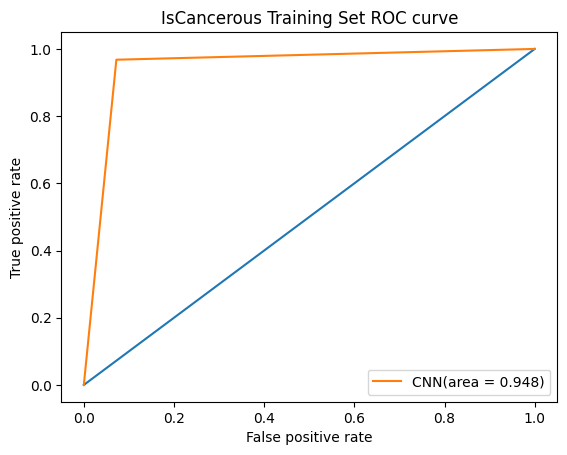

ROC (Area): 0.9478681438894067


0.9478681438894067

In [13]:
a2util.getClassificationROC("IsCancerous", "Training", y_train_cancerous, y_train_pred_cancerous)

Now Predict according to the Validation data and evaluate. While looping through here, we will need to get out the Labels from the data loader, because the order of predictions in the batches do not match the order of the original Target values in the dataset (because we turned Shuffle on)

In [14]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

step=0

y_val_cancerous = []
y_val_pred_cancerous = []

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(cancerous_val_dataloader, 0):
    inputs, labels = data


    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)
    class_score, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_val_cancerous.append(labels[j].item())
        y_val_pred_cancerous.append(predicted[j].item())

    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()



print("Evaluate the Validation Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_val_cancerous, y_val_pred_cancerous))

print("\n- Accuracy Score: " + str(accuracy_score(y_val_cancerous, y_val_pred_cancerous)))
print("- Precision Score: " + str(precision_score(y_val_cancerous, y_val_pred_cancerous)))
print("- Recall Score: " + str(recall_score(y_val_cancerous, y_val_pred_cancerous)))
print("- F1 Score: " + str(f1_score(y_val_cancerous, y_val_pred_cancerous)))

Evaluate the Validation Predictions and Error: 

Confusion matrix: 

[[308 100]
 [ 35 588]]

- Accuracy Score: 0.8690591658583899
- Precision Score: 0.8546511627906976
- Recall Score: 0.9438202247191011
- F1 Score: 0.897025171624714


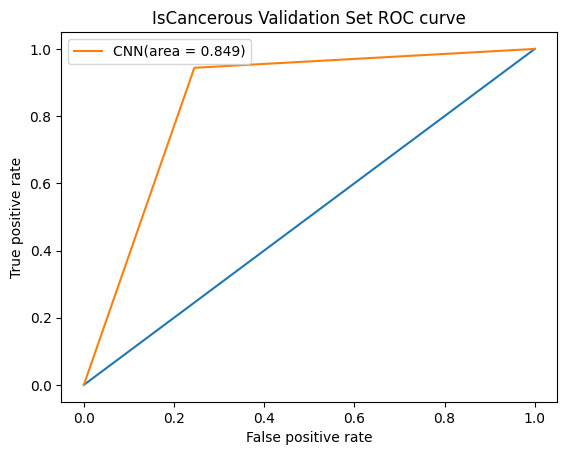

ROC (Area): 0.8493610927517075


0.8493610927517075

In [15]:
a2util.getClassificationROC("IsCancerous", "Validation", y_val_cancerous, y_val_pred_cancerous, 2)

### Results

No L2 Reg or Dropout (from file 06) - On Colab, Full data
- Training Accuracy: 0.969
- Validation: 0.844

L2 with weight_decay=0.0001:
- **Training**
- Accuracy Score: 0.9960444047467143
- Precision Score: 0.998576512455516
- Recall Score: 0.9904694669961172
- F1 Score: 0.9945064681906787
- **Validation**
- Accuracy Score: 0.8516003879728419
- Precision Score: 0.8929765886287625
- Recall Score: 0.8571428571428571
- F1 Score: 0.8746928746928747

L2 with weight_decay=0.001:
- Training Accuracy: 1
- Validation: 0.56
- Very bad on Local with test data, no need to test on colab

Dropout with rate 0.5
- **Training**
- Accuracy Score: 0.9423248692101569
- Precision Score: 0.8836609732516919
- Recall Score: 0.9678785739498764
- F1 Score: 0.923854447439353
- **Validation**
- Accuracy Score: 0.8690591658583899
- Precision Score: 0.8546511627906976
- Recall Score: 0.9438202247191011
- F1 Score: 0.897025171624714


Dropout with rate 0.25
- Training Accuracy: 1
- Validation: 0.82
- not as good as 0.5 in test, no need to test on colab

Now also train a model for CellType Predictions

In [16]:
# Create a custom Dataset for the training and validation data
celltype_training_data = CancerCellTypeDataset(isGoogleColab, dfImagesTrain, baseDirectory, transform=transform_normalize)
celltype_validation_data = CancerCellTypeDataset(isGoogleColab, dfImagesVal, baseDirectory, transform=transform_normalize)

# Create data loaders
celltype_train_dataloader = DataLoader(celltype_training_data, batch_size=32, shuffle=True, num_workers=4)
celltype_val_dataloader = DataLoader(celltype_validation_data, batch_size=32, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Create a class for the Cell Type Neural Network model. The structure of the class will be fundamentally the same, only the model will need to output 4 classes

In [17]:
# Create a class for the Neural Network
class PT_NN_CellType(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self):
        super(PT_NN_CellType, self).__init__()
        self.fc1 = nn.Linear(27 * 27 * 3, 1458)
        self.fc2 = nn.Linear(1458, 729)
        self.fc3 = nn.Linear(729, 4)

    # Create the forward function, which is used in training
    def forward(self, x):
        # process through each layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        # return the result
        return x


# Create a class for the Neural Network with dropouts
class PT_NN_CellType_Dropout(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self, dropout_prob):
        super(PT_NN_CellType_Dropout, self).__init__()
        self.dropProb = dropout_prob

        # 2 Dropout operations on the first two layers, don't do any dropouts on the output layer
        self.classifier = nn.Sequential(
            nn.Dropout(p=self.dropProb),
            nn.Linear(27 * 27 * 3, 1458),
            nn.ReLU(inplace=True),
            nn.Dropout(p=self.dropProb),
            nn.Linear(1458, 729),
            nn.ReLU(inplace=True),                        
            nn.Linear(729, 4),           
        )

    # Create the forward function, which is used in training
    def forward(self, x):
        # Run the Sequential Classifier Layer
        return self.classifier(x)


Now train the Fully Connected Neural Network Model. Use the same configuration (objective function, optimizer etc) as the Binary Classifier

In [18]:
# set the Learning Rate to use
learning_rate = 0.0001
epochsToUse = 10
dropout_rate = 0.5

criterion = nn.CrossEntropyLoss()

# Use this for L2 Regularization
# net = PT_NN_CellType()
# optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001)

# Use this for dropouts
net = PT_NN_CellType_Dropout(dropout_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

for epoch in range(epochsToUse):
    print("Starting Epoch " + str(epoch) + "...")
    for i, data in enumerate(celltype_train_dataloader, 0):
        # Get the inputs
        inputs, labels = data

        # This should convert the image tensors into vectors
        inputs = inputs.view(-1, 27 * 27 * 3)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Perform Forward and Backward propagation then optimize the weights
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

Starting Epoch 0...
Starting Epoch 1...
Starting Epoch 2...
Starting Epoch 3...
Starting Epoch 4...
Starting Epoch 5...
Starting Epoch 6...
Starting Epoch 7...
Starting Epoch 8...
Starting Epoch 9...


Predict on the Training Set to get the Training Accuracy and Error

In [19]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

y_train_celltype = []
y_train_pred_celltype = []
y_train_pred_celltype_scores = []

showBatch=True

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(celltype_train_dataloader, 0):
    inputs, labels = data

    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)

    # outputs.data contains a tensor of size 4 for each record, with a score for each class. Use max
    # to select the class of the highest score for the prediction.
    class_score, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_train_celltype.append(labels[j].item())
        y_train_pred_celltype.append(predicted[j].item())
        y_train_pred_celltype_scores.append(outputs.data[j].tolist())

    showBatch = False
    
    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


print("Evaluate the Training Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_train_celltype, y_train_pred_celltype))

print("\n- Accuracy Score: " + str(accuracy_score(y_train_celltype, y_train_pred_celltype)))
print("- Precision Score: " + str(precision_score(y_train_celltype, y_train_pred_celltype, average="micro")))
print("- Recall Score: " + str(recall_score(y_train_celltype, y_train_pred_celltype, average="micro")))
print("- F1 Score: " + str(f1_score(y_train_celltype, y_train_pred_celltype, average="micro")))

Evaluate the Training Predictions and Error: 

Confusion matrix: 

[[1243  162  132   56]
 [  35 1935  166   37]
 [  22   51 2757    3]
 [ 142  263  152  681]]

- Accuracy Score: 0.8442005869592957
- Precision Score: 0.8442005869592957
- Recall Score: 0.8442005869592957
- F1 Score: 0.8442005869592957


In [20]:
for i in range(5):
    print(y_train_pred_celltype_scores[i])

[3.2965493202209473, -1.3569122552871704, -2.608558416366577, 0.9293797016143799]
[2.2321314811706543, -1.5306439399719238, -0.38467371463775635, -0.35225075483322144]
[1.0282236337661743, 0.17978477478027344, -4.006352424621582, 3.239739418029785]
[4.31315279006958, -1.845118761062622, -5.996389865875244, 3.3630733489990234]
[0.09076595306396484, 2.6466305255889893, -4.239053726196289, 2.0014889240264893]


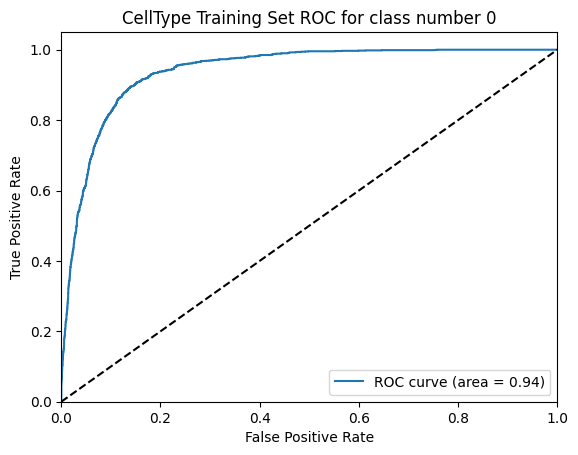

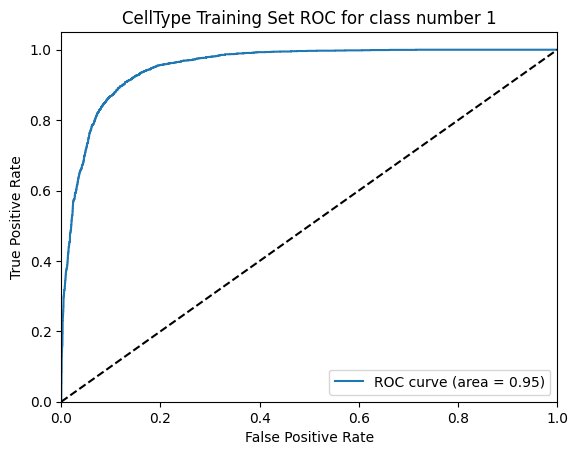

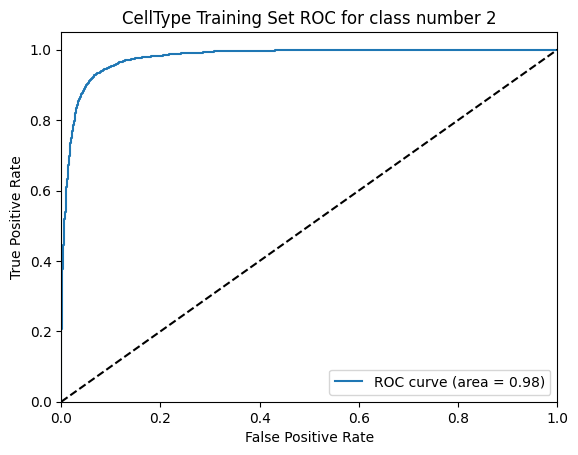

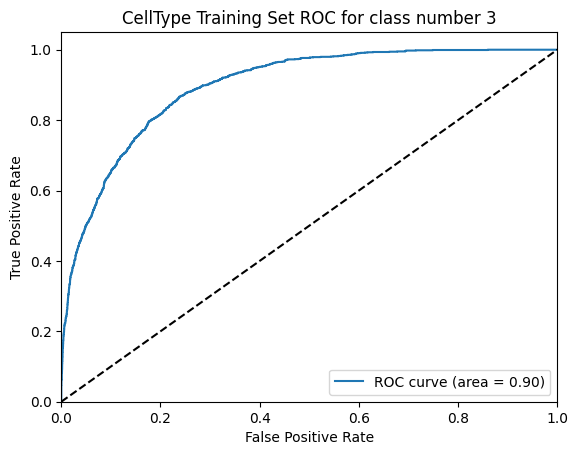

Mean ROC (Area): 0.9414987893792347


0.9414987893792347

In [21]:
a2util.getClassificationROC("CellType", "Training", y_train_celltype, y_train_pred_celltype, 4, y_train_pred_celltype_scores)

Predict on the Validation data and evaluate the results

In [22]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

step=0

y_val_celltype = []
y_val_pred_celltype = []
y_val_pred_celltype_scores = []

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(celltype_val_dataloader, 0):
    inputs, labels = data

    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)
    class_score, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_val_celltype.append(labels[j].item())
        y_val_pred_celltype.append(predicted[j].item())
        y_val_pred_celltype_scores.append(outputs.data[j].tolist())

    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


accuracy = (correct/total) * 100
print("Evaluate the Validation Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_val_celltype, y_val_pred_celltype))

print("\n- Accuracy Score: " + str(accuracy_score(y_val_celltype, y_val_pred_celltype)))
print("- Precision Score: " + str(precision_score(y_val_celltype, y_val_pred_celltype, average="micro")))
print("- Recall Score: " + str(recall_score(y_val_celltype, y_val_pred_celltype, average="micro")))
print("- F1 Score: " + str(f1_score(y_val_celltype, y_val_pred_celltype, average="micro")))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Evaluate the Validation Predictions and Error: 

Confusion matrix: 

[[ 68  27  43  17]
 [  5 144  29   7]
 [ 10  27 584   2]
 [  4  25  33   6]]

- Accuracy Score: 0.7778855480116392
- Precision Score: 0.7778855480116392
- Recall Score: 0.7778855480116392
- F1 Score: 0.7778855480116392


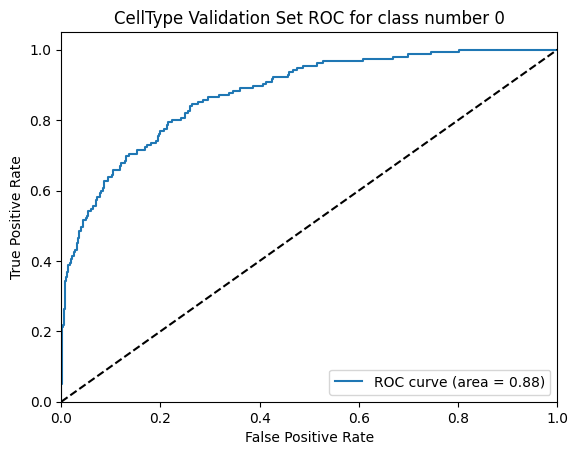

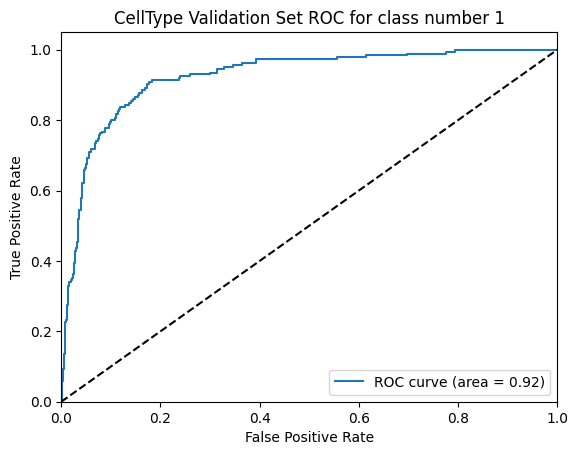

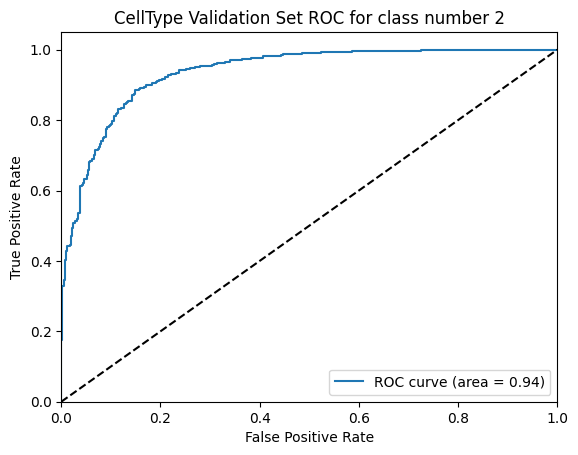

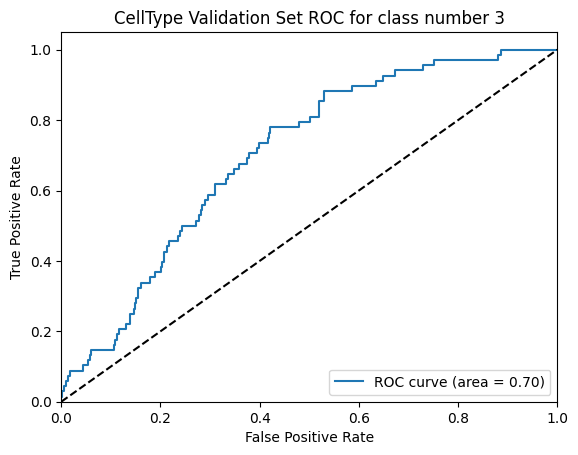

Mean ROC (Area): 0.858878100888927


0.858878100888927

In [23]:
a2util.getClassificationROC("CellType", "Validation", y_val_celltype, y_val_pred_celltype, 4, y_val_pred_celltype_scores)

### Results

No L2 Reg or Dropout (from file 06) - On Colab, Full data
- Training Accuracy: 0.995
- Validation: 0.763

L2 with weight_decay=0.0001:
- **Training**
- Accuracy Score: 0.988898813321424
- Precision Score: 0.988898813321424
- Recall Score: 0.988898813321424
- F1 Score: 0.988898813321424
- **Validation**
- Accuracy Score: 0.7371483996120272
- Precision Score: 0.7371483996120272
- Recall Score: 0.7371483996120272
- F1 Score: 0.7371483996120272

L2 with weight_decay=0.001:
- Training Accuracy: 1
- Validation: 0.56
- Very bad

Dropout with rate 0.5
- **Training**
- Accuracy Score: 0.8442005869592957
- Precision Score: 0.8442005869592957
- Recall Score: 0.8442005869592957
- F1 Score: 0.8442005869592957
- **Validation**
- Accuracy Score: 0.7778855480116392
- Precision Score: 0.7778855480116392
- Recall Score: 0.7778855480116392
- F1 Score: 0.7778855480116392


Dropout with rate 0.25
- Training Accuracy: 1
- Validation: 0.82

<h1>Analysis of Performance and Accuracy</h1>

<strong>Binary Classification - IsCancerous</strong>
<p>
In this model we see that the model has a very low training error and a high accuracy value, in this experiment achieving a 100% accuracy. This indicates that the model has <strong>low bias</strong>. However, when predicting on the validation dataset, the validation error rises. It can be seen that the Accuracy for the validation predictions is 84%, and the are under the ROC Curve is significantly less, with a value of 0.82. This is an indication of <strong>high variance</strong>, and in combination with low bias, indicates a possible problem of <strong>overfitting</strong>
</p>

<strong>Multi-class Classification - Cell Type</strong>
<p>
Similarly, the Cell Type model has a very low training error and a high accuracy value of 99.17%, indicating that the model has <strong>low bias</strong>. However, the Cell Type model has a considerably worse accuracy of only 72.94% when predicting on the validation dataset. A ROC curve is generated for each class, and it can be seen that the model performs better at predicting some classes compared to others. The average the under the ROC Curve score, with a value of 0.84. This indication of <strong>high variance</strong>, and in combination with low bias, indicates a possible problem of <strong>overfitting</strong>.
</p>


<strong>Next Steps</strong>
<p>
Before fully understanding this model configuration and exploring possible different models, first attempt to improve the performance of this model and fix any issues it might have
</p>
<p>
Common methods to deal with overfitting is to apply some form of regularization, such as Early Stopping or Dropout
</p>
<p>
Additionally, we can attempt to improve the accuracy in general with some methods such as adding additional layers and/or neurons per layer. However, this isn't too useful at this stage since the training accuracy is very high, indicating the complexity of the model at this stage is sufficient to capture enough complexity for good prediction.
</p>

